In [2]:
from IPython.display import Image
%matplotlib inline

단층신경망

In [3]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_01.png', width=600)

다층신경망

In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_02.png', width=600)

정방향 계산으로 신경망 활성화 출력 계산

In [23]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784',version=1, return_X_y=True, parser='auto')
X=X.values
y=y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [24]:
X = ((X / 255) - 0.5)*2

각 클래스의 첫 번째 이미지를 그린다

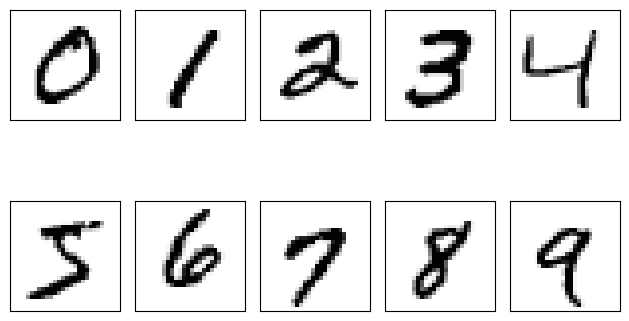

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
  img = X[y==i][0].reshape(28,28)
  ax[i].imshow(img, cmap='Greys')
  ax[i].set_xticks([])
  ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
X_temp, X_test,y_temp,y_test =  train_test_split(X,y,test_size=10000,random_state=123,stratify=y)
X_train, X_valid,y_train,y_valid =  train_test_split(X_temp,y_temp,test_size=5000,random_state=123,stratify=y_temp)

# 데이터 분할용으로 사용한 변수는 삭제해서  memory 용량 확보
del X_temp, y_temp, X,y

다층 퍼셉트론 구현

In [17]:
import numpy as np

In [ ]:
rng = np.random.RandomState(10)
rng.normal(
        loc=0.0, scale=0.1,size=(10,10))

In [19]:
def sigmoid(z):
  return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
  ary = np.zeros( (y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1
  return ary

class NeuralNetMLP:
  def __init__(self,num_features, num_hidden, num_classes, random_seed=123) -> None:
    super().__init__()
    self.num_classes = num_classes
    # 은닉층
    rng = np.random.RandomState(random_seed)

    self.weight_h = rng.normal(
        loc=0.0, scale=0.1,size=(num_hidden,num_features))
    self.bias_h = np.zeros(num_hidden)
    # 출력층
    self.weight_out = rng.normal(
        loc=0.0,scale=0.1,size=(num_classes,num_hidden))
    self.bias_out = np.zeros(num_classes)

  def forward(self,x):
    # 은닉층
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # 출력층
    z_out = np.dot(a_h,self.weight_out.T)*self.bias_out
    a_out = sigmoid(z_out)
    return a_h, a_out

  def backward(self, x, a_h, a_out, y):
    # 출력 가중치
    # 원-핫 인코딩
    y_onehot =  int_to_onehot(y, self.num_classes)
    # 입력/출력
    d_loss__d_a_out = 2*(a_out - y_onehot) / y.shape[0]
    # 입력/출력
    d_a_out__d_z_out = a_out * (1 - a_out)  # sigmoid activative
    # 출력
    delta_out = d_loss__d_a_out * d_a_out__d_z_out

    # 출력 가중치를 위한 그레이디언트
    d_z_out__dw_out = a_h

    # 입력차원
    # 출력차원
    d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
    d_loss__db_out = np.sum(delta_out, axis=0)

    ###########################
    # 은닉층 가중치에 대한 그레이디언트 계산 출력층의 delta_out 과 출력층 가중치를 내적하여 은닉층의 활성화 값에 대한 그레이디언트 계산
    d_z_out__a_h = self.weight_out
    # 출력차원
    d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
    d_a_h__d_z_h = a_h*(1. - a_h)  # sigmoid activation
    d_z_h__d_w_h = x
    # 출력차원
    d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
    d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
    return(d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)





In [20]:
model = NeuralNetMLP(num_features=28*28,num_hidden=50,num_classes=10)

신경망 훈련 루프 코딩
  - 데이터 로더 정의하기

In [21]:
import numpy as np
num_epochs = 50
minibatch_size = 100

In [27]:
def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

# 훈련 에포크를 반복
for i in range(num_epochs):
  # 미니배치 반복
  minibach_gen = minibatch_generator(X_train,y_train,minibatch_size)
  for X_train_mini, y_train_mini in minibach_gen:
    break
  break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


손실 및 정확도를 계산하는 함수 정의하기

In [28]:
def mse_loss(targets,probas,num_labels=10):
  onehot_targets = int_to_onehot(targets, num_labels=num_labels)
  return np.mean((onehot_targets - probas)**2)

def accuracy(targets,predicted_labels)  :
  return np.mean(predicted_labels == targets)

_,probas =  model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f"검증 세트 MSE : {mse:.1f}")
print(f"검증 세트 정확도:{acc*100: .1f}")

검증 세트 MSE : 0.2
검증 세트 정확도: 9.9


In [30]:
def compute_mse_and_acc(nnet, X, y ,num_labels=10, minibatch_size=100):
  mse,correct_pred, num_examples = 0,0,0
  minibatch_gen = minibatch_generator(X,y,minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(targets,num_labels = num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
  mse = mse/i
  acc = correct_pred / num_examples
  return mse, acc

In [33]:
mse,acc = compute_mse_and_acc(model,X_valid,y_valid)
print(f"검증 세트 MSE:{mse:.5f}")
print(f"검증 세트 정확도:{acc*100:.5f}")

검증 세트 MSE:0.00000
검증 세트 정확도:9.86000


훈련함수 정의
  - 에포크 수 만큼 순환